In [1]:
# import libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
import functions
import numpy as np
from datetime import date

In [2]:
# import the DataFrame from your dir 
input_dir = 'C:/Users/valer/OneDrive/Desktop/python/input/'
file_path_eu = os.path.join(input_dir, 'df_eu_analysis.csv')
file_path_us = os.path.join(input_dir, 'df_ofac_analysis.csv')
file_path_uk = os.path.join(input_dir, 'df_uk_analysis.csv')
file_path_ch = os.path.join(input_dir, 'df_ch_analysis.csv')
df_eu = pd.read_csv(file_path_eu, sep=';')
df_ofac = pd.read_csv(file_path_us, sep=';')
df_uk = pd.read_csv(file_path_uk, sep=';')
df_ch = pd.read_csv(file_path_ch, sep=';')

In [3]:
# standardize the 'sanctioned_type' as OFAC entries
df_eu['sanctioned_type'] = df_eu['sanctioned_type'].str.replace('E', 'Entity')
df_eu['sanctioned_type'] = df_eu['sanctioned_type'].str.replace('P', 'Individual')

In [4]:
# I'm concatenating the DataFrames and getting rid of all the records with null 'sanctioned_id'. 
# There are some, should investigate why but they are few, so it's a negligible nloss of data
df_analysis = pd.concat([df_ofac, df_eu, df_uk, df_ch], ignore_index=True)
df_analysis = df_analysis.dropna(subset='sanctioned_id')
df_analysis = df_analysis.drop_duplicates()

In [5]:
# now I'm filling NaN values in 'sanctioned_country_iso3' with the iso2 codes, then I will translate them in iso3 to have a coherent uniwue column
df_analysis['sanctioned_country_iso3'] = df_analysis['sanctioned_country_iso3'].fillna(df_analysis['sanctioned_country_iso2'].apply(functions.iso2_to_iso3))
df_analysis = df_analysis.dropna(subset='sanction_listing_date')

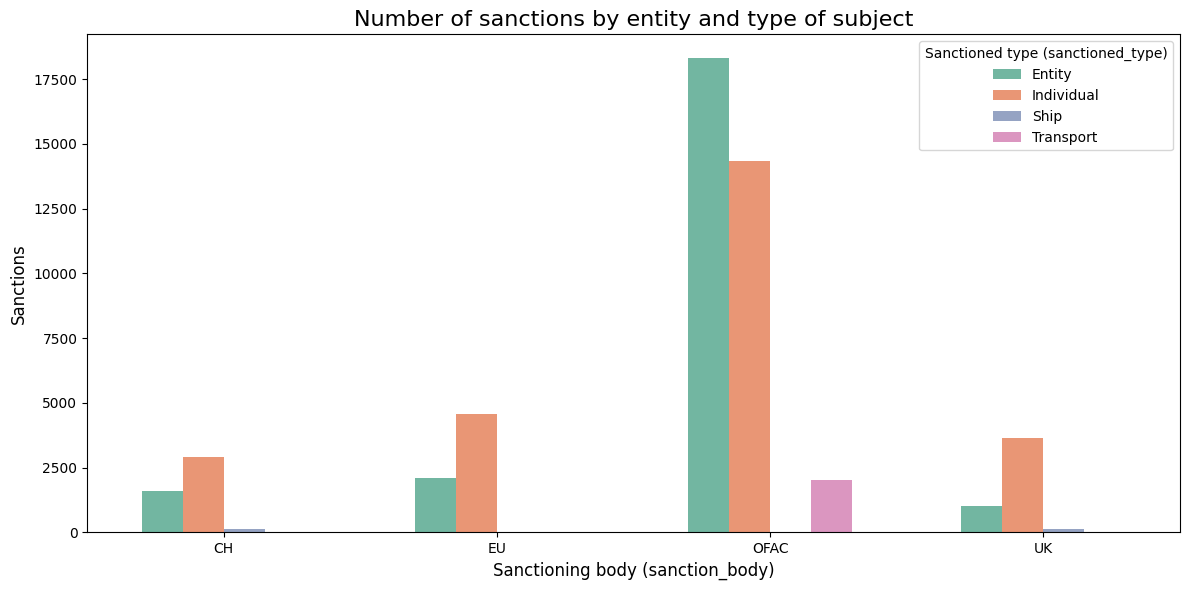

In [13]:
# first plot is a bar plot: for each 'sanction_body', count of each 'sanctioned_type'
# data aggregation
df_grouped = df_analysis.groupby(['sanction_body', 'sanctioned_type']).size().reset_index(name='num_sanctions')

# bar plot creation
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_grouped, 
    x='sanction_body', 
    y='num_sanctions', 
    hue='sanctioned_type', 
    palette='Set2',
    dodge=True,  # holds the aggregation
    width=0.6    # bar width
)

# some custom stuff
plt.title("Number of sanctions by entity and type of subject", fontsize=16)
plt.xlabel("Sanctioning body (sanction_body)", fontsize=12)
plt.ylabel("Sanctions", fontsize=12)
plt.legend(title="Sanctioned type (sanctioned_type)")
plt.tight_layout()

# save the plot as a file
plt.savefig('C:/Users/valer/OneDrive/Desktop/python/output/plot_1.png', format='png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

C:\Users\valer\AppData\Local\Temp\ipykernel_8700\301644237.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_data = pd.DataFrame(index=all_years, columns=all_bodies).fillna(0)


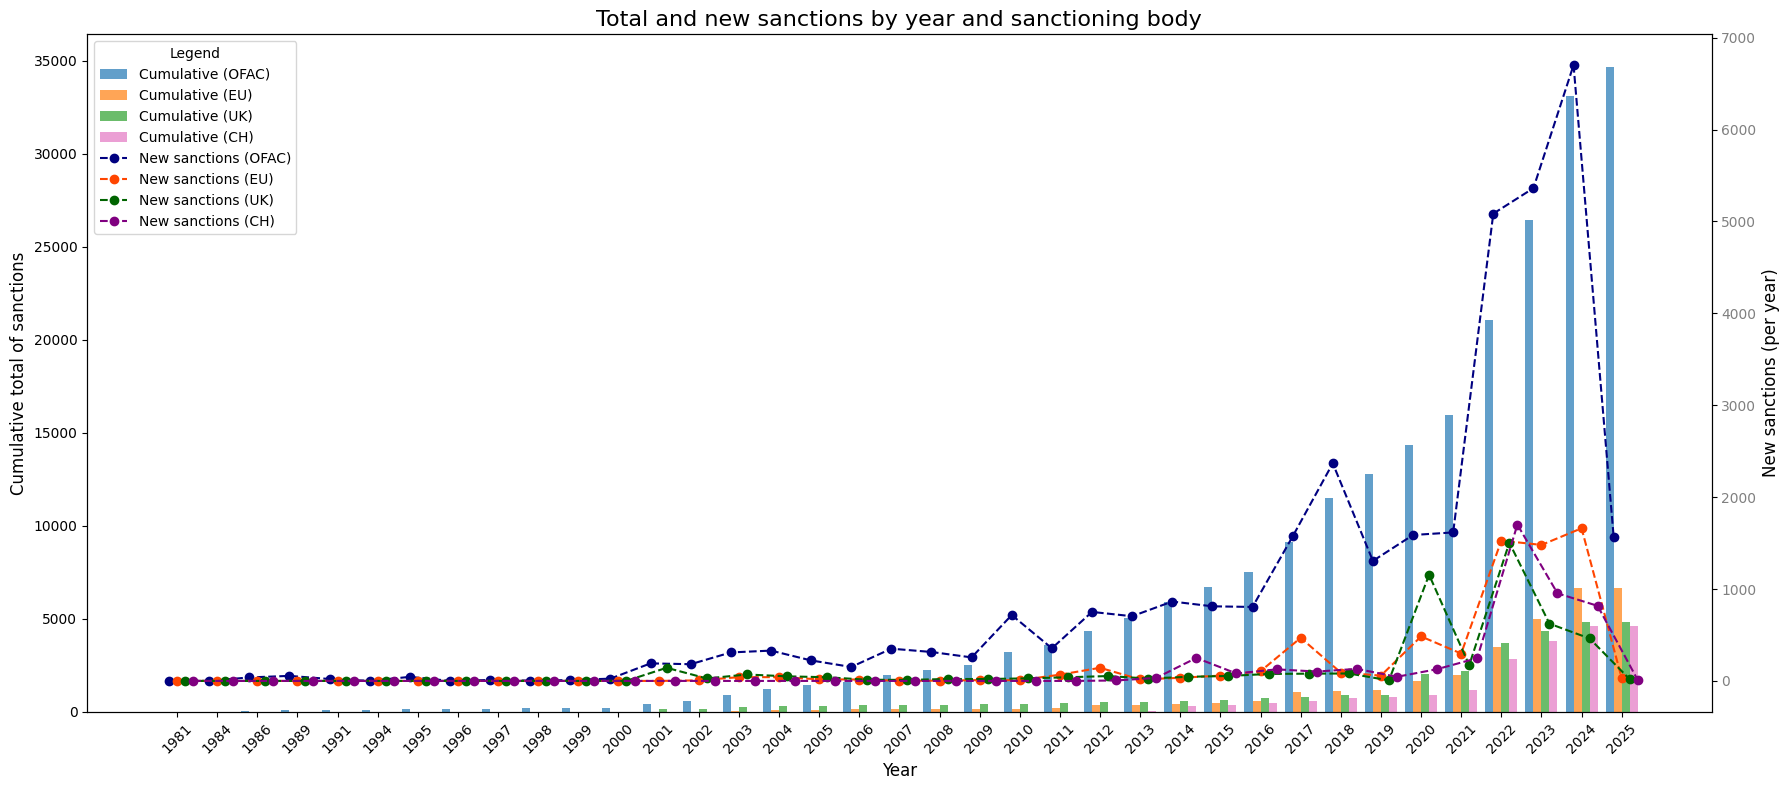

In [16]:
# second plot is a mixed bar plot and trend plot: 
# bar plot: for each 'sanction_body', cumulative sanctions per year
# trend plot: for each 'sanction_body', new sanctions per year

# a bit of data manipulation to extract the year from the listing date
df_analysis['sanction_listing_date'] = pd.to_datetime(df_analysis['sanction_listing_date'])
df_analysis['sanction_year'] = df_analysis['sanction_listing_date'].dt.year
df_new = df_analysis.groupby(['sanction_year', 'sanction_body']).size().reset_index(name='new_sanctions')

# pivot table
all_years = sorted(df_analysis['sanction_year'].unique())
all_bodies = df_analysis['sanction_body'].unique()
pivot_data = pd.DataFrame(index=all_years, columns=all_bodies).fillna(0)

for index, row in df_new.iterrows():
    pivot_data.at[row['sanction_year'], row['sanction_body']] = row['new_sanctions']

pivot_data = pivot_data.fillna(0)

# cumulative sanctions per year by sanction_body
cumulative_data = pivot_data.cumsum()

# custom colors 
custom_colors_bar = {
    "OFAC": "tab:blue",  # blue
    "EU": "tab:orange",  # orange
    "UK": "tab:green", 
    "CH": "tab:pink"
}

fig, ax1 = plt.subplots(figsize=(18, 8))

# 1. grouped bar plot: cumulative sanctions per year by sanction_body
bar_width = 0.2  # Width of each bar
offset = np.arange(len(cumulative_data.index))  # base positions for each year

for i, body in enumerate(cumulative_data.columns):
    ax1.bar(
        offset + i * bar_width,  # offset for each sanction body
        cumulative_data[body], 
        width=bar_width, 
        label=f"Cumulative ({body})", 
        alpha=0.7, 
        color=custom_colors_bar.get(body, "#7f7f7f")  # grey as fallback
    )

ax1.set_ylabel("Cumulative total of sanctions", fontsize=12)
ax1.set_xlabel("Year", fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticks(offset + (len(cumulative_data.columns) - 1) * bar_width / 2)
ax1.set_xticklabels(cumulative_data.index)
ax1.set_title("Total and new sanctions by year and sanctioning body", fontsize=16)

# 2. trend plot: for each 'sanction_body', new sanctions per year
ax2 = ax1.twinx()  # secondary axis

custom_colors_trend = {
    "OFAC": "navy", 
    "EU": "orangered",
    "UK": "darkgreen",
    "CH": "purple"
}

for i, body in enumerate(pivot_data.columns):
    ax2.plot(
        offset + i * bar_width + bar_width / 2,  # align with the center of each group's bars
        pivot_data[body], 
        marker='o', 
        linestyle='--', 
        color=custom_colors_trend.get(body, "#7f7f7f"),  # grey as fallback
        label=f"New sanctions ({body})"
    )

ax2.set_ylabel("New sanctions (per year)", fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray')

# Combined legend for both plots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left', title="Legend")

plt.tight_layout()

# save the plot as a file
plt.savefig('C:/Users/valer/OneDrive/Desktop/python/output/plot_2.png', format='png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()

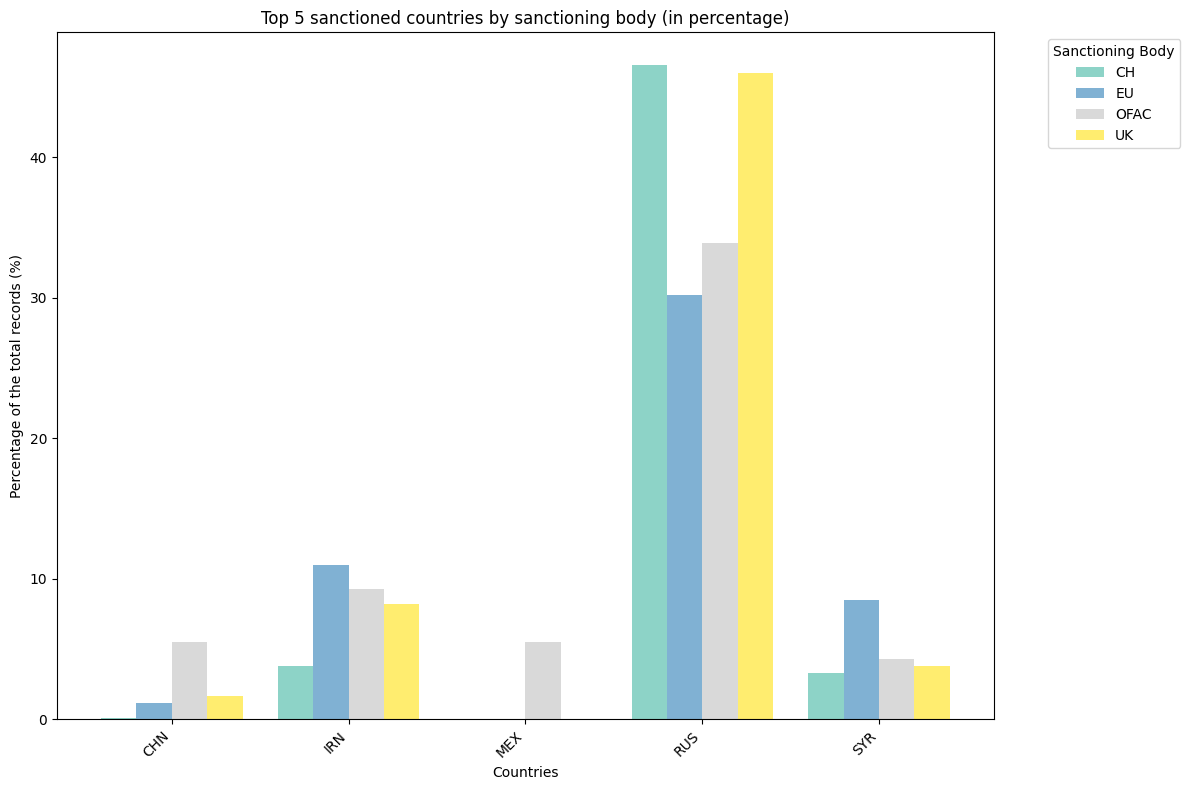

In [15]:
# third plot: top 5 sanctioned countries by sanctioning body (in percentage)
# I use percentages because OFAC has a significantly larger number of sanctions compared to the EU

# total sanctioned subjects for each combination
total_by_country = (
    df_analysis.groupby(['sanction_body', 'sanctioned_country_iso3'])
    .size()
    .reset_index(name='total_sanctions')
)

# total by sanctioning body
total_by_body = total_by_country.groupby('sanction_body')['total_sanctions'].sum().reset_index(name='total_body_sanctions')

total_by_country = total_by_country.merge(total_by_body, on='sanction_body')
total_by_country['percentage'] = (total_by_country['total_sanctions'] / total_by_country['total_body_sanctions']) * 100

# top 5 countries selection
top_countries = (
    total_by_country.groupby('sanctioned_country_iso3')['total_sanctions']
    .sum()
    .nlargest(5)
    .index
)

top_5_countries = total_by_country[total_by_country['sanctioned_country_iso3'].isin(top_countries)]

# pivot table
pivot_data = top_5_countries.pivot_table(
    index='sanctioned_country_iso3',
    columns='sanction_body',
    values='percentage',
    fill_value=0
)

pivot_data.plot(
    kind='bar',
    figsize=(12, 8),
    width=0.8,
    colormap='Set3' 
)

plt.ylabel('Percentage of the total records (%)')
plt.xlabel('Countries')
plt.title('Top 5 sanctioned countries by sanctioning body (in percentage)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sanctioning Body', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# save the plot as a file
plt.savefig('C:/Users/valer/OneDrive/Desktop/python/output/plot_3.png', format='png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

plt.show()